In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm


In [56]:
epl = pd.read_csv("epl_locked.csv")

In [68]:
epl.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Team', 'Player', 'Pageviews', 'G', 'Min',
       'Start', 'Sub', 'Gls', 'Ast', 'NPG', 'PK', 'Sh', 'SoT', 'SoT%',
       'ShDist', 'FK', 'PaCmp', 'PaCmp%', 'KP', 'Crs', 'PrgP', 'Car',
       'TotDist', 'PrgC', 'Mis', 'Dis', 'TOnAtt', 'TOnSucc', 'TOnSucc%', 'Tkl',
       'TklW', 'Def_3rd', 'Mid_3rd', 'Att_3rd', 'Blck', 'Int', 'Clr', 'Err',
       'DuelW', 'DuelW%', 'CrdY', 'CrdR', 'Fls', 'Fld', 'Off', 'OG', 'Recov',
       'GA', 'Sv', 'Sv%', 'CS', 'CS%', 'Pos', 'BdOr', 'GBoot', 'GGlove',
       'POTY', 'TOTY', 'WC', 'Euro', 'UCL', 'Prem'],
      dtype='object')

In [57]:
# epl

In [58]:
# epl.columns

In [59]:
# drop_cols = [
#     'Wikipedia_Link',
#     'ID',
#     'Player_df1_x',
#     'Until',
#     'Team_df2_y',
#     'df2_index',
#     'df1_index',
#     'Player_df1_y',
#     'Player_df2_y',
#     'Match Score',
#     'IG',
#     'Team_df1'
# ]

In [60]:
# epl_dropped = epl.drop(columns=drop_cols)

In [61]:
# def clean_primary_position(df, col='Pos', new_col='Pos'):
#     """
#     Extracts the first position from a comma-separated 'Pos' column.
    
#     Args:
#         df (pd.DataFrame): Your DataFrame
#         col (str): Name of the column containing positions
#         new_col (str): Name of the new column to create

#     Returns:
#         pd.DataFrame: Updated DataFrame with a new 'PrimaryPos' column
#     """
#     df[new_col] = df[col].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else x)
#     return df


In [62]:
# epl_dropped = clean_primary_position(epl_dropped)

In [63]:
# epl_dropped.to_csv("epl_locked.csv")

In [64]:
# epl_dropped.columns

In [65]:
# epl_dropped = epl_dropped.rename(columns={
#     "Player_df2_x": "Player", 
#     "Team_df2_x": "Team",
#     "MP": "G"
#     })


In [ ]:
def compute_obscurity_scores(csv_file, output_file=None):
    """
    Compute obscurity scores for EPL players using deep learning.

    This function:
    1. Loads EPL player data
    2. Processes and normalizes relevant features
    3. Creates a custom deep learning model
    4. Computes obscurity scores (100 = most obscure, 0 = least obscure)
    5. Returns dataframe with added obscurity scores

    Args:
        csv_file (str): Path to CSV file with EPL player data
        output_file (str, optional): Path to save results. If None, doesn't save.

    Returns:
        pandas.DataFrame: Player data with computed obscurity scores
    """
    # 1. Load and prepare the data
    df = pd.read_csv(csv_file)

    # Clean the data
    df = df.fillna(0)

    # 2. Feature extraction & engineering

    # A. Basic visibility features
    # Pageviews - direct measure of visibility (inverse relation to obscurity)
    if 'Pageviews' in df.columns:
        df['pageviews_factor'] = df['Pageviews']
    else:
        # If no pageviews data, estimate from games played and awards
        df['pageviews_factor'] = df['G'] * 5000

    # B. Accomplishment features
    # Combine awards
    df['awards_count'] = df['BdOr'] + df['GBoot'] + \
        df['GGlove'] + df['POTY'] + df['TOTY'] + df['WC'] + \
        df['Euro'] + df['UCL'] + df['Prem']

    # C. Position-specific performance metrics
    # For QBs
    df['fw_career_value'] = 0
    fw_mask = df['Pos'] == 'FW'
    if fw_mask.any():
        df.loc[fw_mask, 'fw_career_value'] = (
        df.loc[fw_mask, 'Gls'] * 4.0 +
        df.loc[fw_mask, 'NPG'] * 3.5 +
        df.loc[fw_mask, 'PK'] * 1.0 +
        df.loc[fw_mask, 'Sh'] * 1.5 +
        df.loc[fw_mask, 'SoT'] * 2.0 +
        df.loc[fw_mask, 'SoT%'] * 1.5 +
        df.loc[fw_mask, 'ShDist'] * 0.5 +
        df.loc[fw_mask, 'KP'] * 2.0 +
        df.loc[fw_mask, 'PrgP'] * 1.5 +
        df.loc[fw_mask, 'PrgC'] * 1.5 +
        df.loc[fw_mask, 'Ast'] * 3.0 +
        df.loc[fw_mask, 'Off'] * 1.0 +
        df.loc[fw_mask, 'Fld'] * 0.5 +
        df.loc[fw_mask, 'OG'] * -2.0 +
        df.loc[fw_mask, 'TOnSucc%'] * 1.0
    )


    # For RBs
    df['mf_career_value'] = 0
    mf_mask = df['Pos'] == 'MF'
    if mf_mask.any():
        df.loc[mf_mask, 'mf_career_value'] = (
            df.loc[mf_mask, 'KP'] * 2.5 +
            df.loc[mf_mask, 'PaCmp'] * 2.0 +
            df.loc[mf_mask, 'PaCmp%'] * 2.5 +
            df.loc[mf_mask, 'PrgP'] * 2.0 +
            df.loc[mf_mask, 'Crs'] * 1.5 +
            df.loc[mf_mask, 'Car'] * 1.5 +
            df.loc[mf_mask, 'PrgC'] * 2.0 +
            df.loc[mf_mask, 'TOnAtt'] * 1.0 +
            df.loc[mf_mask, 'TOnSucc'] * 1.0 +
            df.loc[mf_mask, 'TOnSucc%'] * 1.0 +
            df.loc[mf_mask, 'Ast'] * 2.0 +
            df.loc[mf_mask, 'Sh'] * 1.0 +
            df.loc[mf_mask, 'Fld'] * 1.0 +
            df.loc[mf_mask, 'Int'] * 1.5 +
            df.loc[mf_mask, 'Recov'] * 1.0 +
            df.loc[mf_mask, 'Err'] * -1.5
        )

    # For WRs/TEs
    df['df_career_value'] = 0
    df_mask = (df['Pos'] == 'DF')
    if df_mask.any():
        df.loc[df_mask, 'df_career_value'] = (
            df.loc[df_mask, 'Tkl'] * 2.5 +
            df.loc[df_mask, 'TklW'] * 2.0 +
            df.loc[df_mask, 'Def_3rd'] * 2.0 +
            df.loc[df_mask, 'Mid_3rd'] * 1.0 +
            df.loc[df_mask, 'Blck'] * 2.0 +
            df.loc[df_mask, 'Int'] * 2.5 +
            df.loc[df_mask, 'Clr'] * 2.5 +
            df.loc[df_mask, 'Err'] * -2.0 +
            df.loc[df_mask, 'OG'] * -3.0 +
            df.loc[df_mask, 'Fls'] * -1.0 +
            df.loc[df_mask, 'CrdY'] * -1.5 +
            df.loc[df_mask, 'CrdR'] * -3.0 +
            df.loc[df_mask, 'DuelW'] * 2.0 +
            df.loc[df_mask, 'DuelW%'] * 1.5 +
            df.loc[df_mask, 'Recov'] * 1.5
        )
    # For defensive players
    df['gk_career_value'] = 0
    gk_mask = (df['Pos'] == 'GK')
    if gk_mask.any():
        df.loc[gk_mask, 'gk_career_value'] = (
        df.loc[gk_mask, 'GA'] * -3.0 +
        df.loc[gk_mask, 'Sv'] * 3.0 +
        df.loc[gk_mask, 'Sv%'] * 3.5 +
        df.loc[gk_mask, 'CS'] * 3.0 +
        df.loc[gk_mask, 'CS%'] * 3.0 +
        df.loc[gk_mask, 'Err'] * -3.0 +
        df.loc[gk_mask, 'Blck'] * 1.0 +
        df.loc[gk_mask, 'Clr'] * 1.0
    )

    # Combine all position values into a single career value metric
    career_value_cols = ['fw_career_value', 'mf_career_value',
                         'df_career_value', 'gk_career_value']
    df['career_value'] = df[career_value_cols].max(axis=1)

    # D. Career longevity and volume
    df['games_factor'] = df['G'] / df['G'].max() if df['G'].max() > 0 else 0

    # 3. Calculate the base obscurity score using key metrics

    # A. Extract normalized key metrics (higher = less obscure)
    # Reverse the logic: higher values in these metrics = lower obscurity
    metrics = pd.DataFrame()

    # Normalize each metric to 0-1 range
    if df['pageviews_factor'].max() > 0:
        metrics['pageviews'] = df['pageviews_factor'] / \
            df['pageviews_factor'].max()
    else:
        metrics['pageviews'] = 0

    # Normalizing assuming 10 awards is maximum
    metrics['awards'] = df['awards_count'] / 10
    metrics['career_value'] = df['career_value'] / \
        df['career_value'].max() if df['career_value'].max() > 0 else 0
    metrics['games'] = df['games_factor']
    # B. Calculate the visibility score (inverse of obscurity)
    # Weight the metrics based on importance
    weights = {
        'pageviews': 0.6,
        'awards': 0.3,
        'career_value': 0.2,
        'games': 0.05,
    }

    visibility_score = (
        metrics['pageviews'] * weights['pageviews'] +
        metrics['awards'] * weights['awards'] +
        metrics['career_value'] * weights['career_value'] +
        metrics['games'] * weights['games']
    )

    # C. Convert visibility to obscurity (100 = most obscure, 0 = least obscure)
    df['obscurity_score_basic'] = 100 * (1 - visibility_score)

    # 4. Deep Learning Enhancement
    # Use a neural network to capture more complex relationships

    # A. Prepare features for deep learning
    feature_cols = [
        'pageviews_factor', 'awards_count', 'career_value',
        'G', 'Start'
    ]

    categorical_cols = ['Pos']

    # Fill any NaNs created during the calculation
    df = df.fillna(0)

    # Select features and preprocess
    X = df[feature_cols + categorical_cols]

    # Create preprocessing pipeline with sparse output for categorical features
    numerical_transformer = StandardScaler()

    # Use sparse output for OneHotEncoder to save memory
    categorical_transformer = OneHotEncoder(
        handle_unknown='ignore', sparse_output=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, feature_cols),
            ('cat', categorical_transformer, categorical_cols)
        ],
        sparse_threshold=0  # Force dense output from the transformer
    )

    # Fit and transform the data
    X_processed = preprocessor.fit_transform(X)

    # B. Build and train the model
    # We'll use the basic obscurity score as a starting point
    # and refine it with the neural network
    initial_obscurity = df['obscurity_score_basic'].values

    # Define the model with memory optimization
    model = keras.Sequential([
        layers.InputLayer(input_shape=(X_processed.shape[1],)),
        layers.Dense(32, activation='relu', use_bias=True),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', use_bias=True),
        layers.Dense(1, activation='sigmoid')  # Output between 0 and 1
    ])

    # Use a memory-efficient optimizer
    optimizer = keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )

    # Train the model to learn from the initial obscurity scores
    # This helps capture complex non-linear relationships

    # Set up callbacks to handle warnings
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=5,
            restore_best_weights=True
        )
    ]

    # Suppress TensorFlow warnings during training
    import os
    import tensorflow as tf
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TF warnings

    # Train with memory-optimized settings
    model.fit(
        X_processed,
        initial_obscurity / 100,  # Scale to 0-1 for training
        epochs=30,  # Reduced epochs
        batch_size=8,  # Increased batch size for better memory efficiency
        callbacks=callbacks,
        verbose=1
    )

    # Make predictions and convert back to 0-100 scale
    refined_obscurity = model.predict(X_processed).flatten() * 100

    # Combine initial and refined scores (giving more weight to refined)
    df['obscurity_score'] = 0.3 * \
        df['obscurity_score_basic'] + 0.7 * refined_obscurity

    # 5. Apply business rules and adjustments

    # A. Award winners should have lower obscurity
    # Super Bowl winners, MVPs, etc. are well-known
    award_winners = df['awards_count'] > 0
    if award_winners.any():
        df.loc[award_winners, 'obscurity_score'] *= 0.8  # Reduce obscurity by 20%

    # B. Long careers lead to more visibility
    long_careers = df['G'] > 100
    if long_careers.any():
        df.loc[long_careers, 'obscurity_score'] *= 0.9  # Reduce obscurity by 10%

    # C. Recent Rookie of the Year winners get more attention
    rookies = (df['BdOr'] > 0)
    if rookies.any():
        df.loc[rookies, 'obscurity_score'] *= 0.85  # Reduce obscurity by 15%

    # D. Clean up final scores
    # Ensure scores are within 0-100 range
    df['obscurity_score'] = df['obscurity_score'].clip(0, 100)

    # E. Transform the distribution to be more normal
    # First, calculate mean and standard deviation of current scores
    mean_score = df['obscurity_score'].mean()
    std_score = df['obscurity_score'].std()

    # If standard deviation is too small, set a minimum value
    std_score = max(std_score, 10)

    # Apply transformation to create more of a normal distribution
    # This uses a logistic function to spread out the values
    from scipy import stats

    # Convert to z-scores first
    z_scores = (df['obscurity_score'] - mean_score) / std_score

    # Apply sigmoid transformation to spread values more evenly
    transformed_scores = 1 / (1 + np.exp(-z_scores))

    # Scale back to 0-100 range with better spread
    # Adjust these parameters to control the shape of the distribution
    min_target = 5    # Minimum obscurity score
    max_target = 95   # Maximum obscurity score
    range_target = max_target - min_target

    df['obscurity_score_normalized'] = min_target + \
        range_target * transformed_scores

    # Apply a second transformation to improve normality
    # Use percentile rank method to create a more uniform distribution first
    percentile_ranks = df['obscurity_score_normalized'].rank(pct=True)

    # Then transform to normal distribution using inverse normal CDF
    from scipy.stats import norm
    df['obscurity_score'] = norm.ppf(percentile_ranks) * 15 + 50

    # Clip values to ensure they stay in 0-100 range
    df['obscurity_score'] = df['obscurity_score'].clip(0, 100)

    # Round to 2 decimal places
    df['obscurity_score'] = df['obscurity_score'].round(2)

    # 6. Create a scaled version (0-100 scale to 0-50 scale)
    df['obscurity_score_scaled'] = (df['obscurity_score'] * 0.5).round(2)

    # 7. Save the results if output file provided
    if output_file:
        # Select relevant columns for output
        output_df = df.copy()

        # Drop intermediate calculation columns
        cols_to_drop = [
            'pageviews_factor', 'awards_count', 'fw_career_value',
            'mf_career_value', 'df_career_value', 'gk_career_value',
            'career_value', 'games_factor',
            'obscurity_score_basic'
        ]

        # Also drop position-specific columns we created
        pos_cols = [col for col in output_df.columns if any(
            f'{pos}_' in col for pos in df['Pos'].unique())]
        cols_to_drop.extend(pos_cols)

        # Drop columns that exist
        cols_to_drop = [
            col for col in cols_to_drop if col in output_df.columns]
        output_df = output_df.drop(columns=cols_to_drop)

        # Save to CSV
        output_df.to_csv(output_file, index=False)

    # 8. Return the dataframe with obscurity scores
    return df

In [ ]:
# Path to your EPL player data
input_file = "epl_locked.csv"

# Path to save results
output_file = "epl_players_with_obscurity.csv"

# Compute obscurity scores
result_df = compute_obscurity_scores(input_file, output_file)

/tmp/ipykernel_63411/1840847105.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.23220e+03 3.58020e+03 2.47670e+03 3.42545e+03 2.45795e+03 5.72460e+03
 4.68230e+03 3.04025e+03 1.65950e+02 1.50280e+03 3.17850e+02 3.58250e+02
 8.38900e+02 6.92950e+02 1.81550e+02 1.22305e+03 2.80100e+02 0.00000e+00
 0.00000e+00 2.17650e+02 1.39785e+03 7.14150e+02 3.92700e+02 2.68650e+02
 2.61135e+03 1.68720e+03 3.28800e+02 3.26890e+03 4.51650e+02 2.33750e+02
 2.16000e+02 1.22350e+02 1.75075e+03 1.96135e+03 6.68700e+02 1.15305e+03
 1.17330e+03 3.19450e+02 1.35060e+03 2.50000e+00 1.34000e+01 0.00000e+00
 3.09650e+02 1.30335e+03 1.16720e+03 1.18230e+03 2.78035e+03 3.44500e+02
 3.69325e+03 1.23000e+02 5.99550e+02 2.24800e+02 2.90530e+03 1.23670e+03
 5.55350e+02 2.97410e+03 4.00700e+02 4.49125e+03 6.41100e+02 4.46945e+03
 2.42330e+03 7.93550e+02 1.37420e+03 1.92825e+03 1.40645e+03 7.84405e+03
 9.59000e+01 1.35965e+03 1.28

Epoch 1/30


I0000 00:00:1743118457.479762   85977 service.cc:148] XLA service 0x7fadac001840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743118457.479791   85977 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-27 19:34:17.500104: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743118457.580798   85977 cuda_dnn.cc:529] Loaded cuDNN version 90800


28/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2556 - mae: 0.4598 

I0000 00:00:1743118458.376530   85977 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2354 - mae: 0.4358
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0906 - mae: 0.2555
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0399 - mae: 0.1590
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228 - mae: 0.1063
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - mae: 0.0898
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133 - mae: 0.0769
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125 - mae: 0.0695
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089 - mae: 0.0609
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - mae: 0.0555
Epoch 10/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - mae: 0.0564
Epoch 11/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 - mae: 0.0616
Epoch 12/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - mae: 0.0602
Epoch 13/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

In [75]:
# Display results
print("Top 5 Most Obscure Players:")
most_obscure = result_df.sort_values(
      'obscurity_score', ascending=False).head(25)
print(most_obscure[['Player', 'Pos', 'Team', 'G',
      'obscurity_score', 'obscurity_score_scaled']])

print("\nTop 5 Least Obscure Players:")
least_obscure = result_df.sort_values('obscurity_score').head(25)
print(least_obscure[['Player', 'Pos', 'Team', 'G',
      'obscurity_score', 'obscurity_score_scaled']])

print("\n mid  Obscure Players:")
mid_obscure = result_df.sort_values('obscurity_score')
mid_obscure = mid_obscure[175:200]
print(mid_obscure[['Player', 'Pos', 'Team', 'G',
      'obscurity_score', 'obscurity_score_scaled']])

# print(result_df[800:900])

Top 5 Most Obscure Players:
                     Player Pos                     Team   G  obscurity_score  \
67           Ben Winterburn  MF              Bournemouth   2           100.00   
68             Dominic Sadi  MF              Bournemouth   1            92.12   
374          Oliver Scarles  MF          West Ham United   5            88.65   
157             Romain Esse  MF           Crystal Palace   1            86.50   
397           Enso González  MF  Wolverhampton Wanderers   1            84.91   
312   Eric da Silva Moreira  MF        Nottingham Forest   2            83.64   
165            Caleb Kporha  DF           Crystal Palace   2            82.57   
385        Emmanuel Agbadou  DF  Wolverhampton Wanderers   3            81.64   
65               Owen Bevan  DF              Bournemouth   1            80.82   
164          Justin Devenny  MF           Crystal Palace  10            80.09   
150          Matheus França  MF           Crystal Palace  10            79.42   


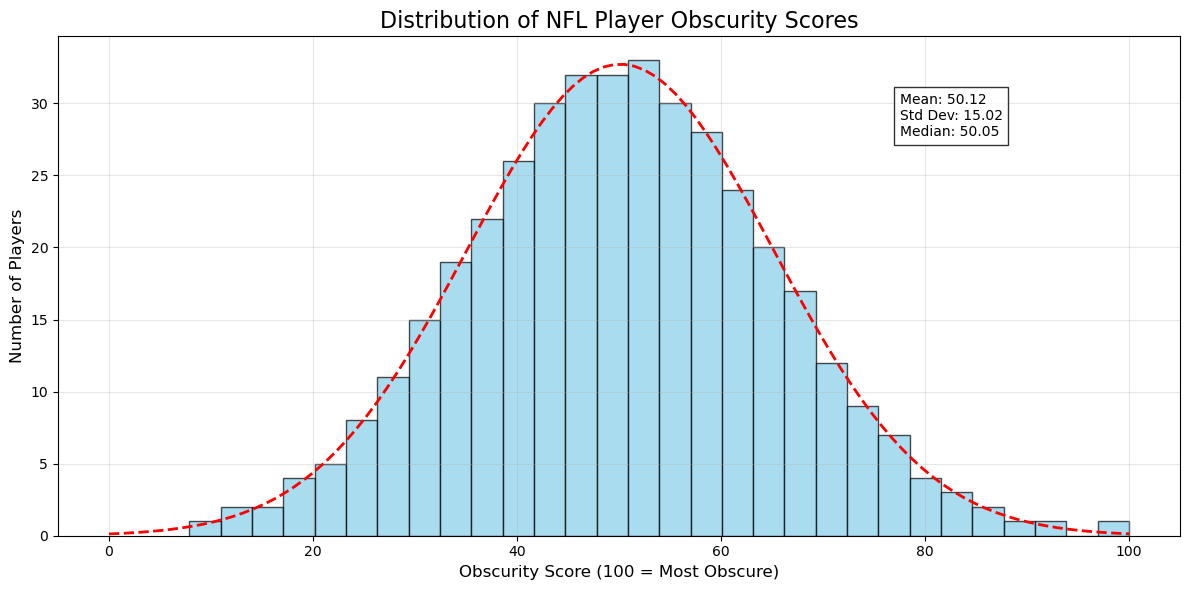

In [ ]:
# Plot distribution of obscurity scores
plt.figure(figsize=(12, 6))

# Create histogram with more granular bins
n, bins, patches = plt.hist(result_df['obscurity_score'], bins=30,
                              color='skyblue', edgecolor='black', alpha=0.7)

# Add a normal curve overlay
mu = result_df['obscurity_score'].mean()
sigma = result_df['obscurity_score'].std()
x = np.linspace(0, 100, 100)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 *
      ((x - mu) / sigma) ** 2)) * len(result_df) * (bins[1] - bins[0])
plt.plot(x, y, 'r--', linewidth=2)

plt.title('Distribution of EPL Player Obscurity Scores', fontsize=16)
plt.xlabel('Obscurity Score (100 = Most Obscure)', fontsize=12)
plt.ylabel('Number of Players', fontsize=12)
plt.grid(alpha=0.3)

# Add descriptive stats as text
stats_text = f"Mean: {mu:.2f}\nStd Dev: {sigma:.2f}\nMedian: {result_df['obscurity_score'].median():.2f}"
plt.text(0.75, 0.8, stats_text, transform=plt.gca().transAxes,
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('obscurity_distribution.png')
